# TP 4: Improve the Metropolis-Hastings algorithm
## Author: Clément Bonnet

---

## Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

## 1.A - Metropolis-Hastings within Gibbs sampler

### 1.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
def pi(x, y, a):
    return np.exp( -x**2/a**2 - y**2 -1/4 * (x**2/a**2 - y**2)**2 )

a = 10
sigma_x = 3
sigma_y = 3

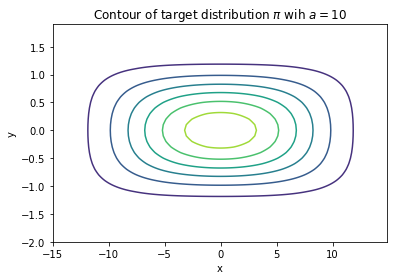

In [3]:
delta = 0.1
x = np.arange(-15.0, 15.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z = np.array([[pi(X[i,j], Y[i,j], a) for j in range(X.shape[1])] for i in range(X.shape[0])])
plt.contour(X,Y,Z);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Contour of target distribution $\pi$ wih $a=10$");

In [4]:
def P1(x, y, n_iter, sigma_x=sigma_x):
    X, Y = [], []
    acc_rate = 0
    for _ in range(n_iter):
        x2 = x + sigma_x*np.random.randn()
        y2 = y
        alpha = min(1, pi(x2, y2, a)/pi(x, y, a))
        if np.random.rand() < alpha:
            x = x2
            y = y2
            acc_rate += 1
        X.append(x)
        Y.append(y)
    acc_rate = acc_rate/n_iter
    return X, Y, acc_rate

def P2(x, y, n_iter, sigma_y=sigma_y):
    X, Y = [], []
    acc_rate = 0
    for _ in range(n_iter):
        x2 = x
        y2 = y + sigma_y*np.random.randn()
        alpha = min(1, pi(x2, y2, a)/pi(x, y, a))
        if np.random.rand() < alpha:
            x = x2
            y = y2
            acc_rate += 1
        X.append(x)
        Y.append(y)
    acc_rate = acc_rate/n_iter
    return X, Y, acc_rate

def P(x, y, n_iter, burn_in=0, sigma_x=sigma_x, sigma_y=sigma_y):
    """
    burn_in: float between 0 and 1 indicating the proportion of data samples from the beginning to delete.
    """
    X, Y = [], []
    acc_rate_x, acc_rate_y = 0, 0
    acc_rates_x, acc_rates_y = [], []
    for i in range(1, n_iter+1):
        if np.random.rand() < 0.5:
            x2 = x + sigma_x*np.random.randn()
            y2 = y
            updated_x = True
        else:
            x2 = x
            y2 = y + sigma_y*np.random.randn()
            updated_x = False
        alpha = min(1, pi(x2, y2, a)/pi(x, y, a))
        if np.random.rand() < alpha:
            x = x2
            y = y2
            if updated_x:
                acc_rate_x += 1
            else:
                acc_rate_y += 1
        acc_rates_x.append(acc_rate_x/i)
        acc_rates_y.append(acc_rate_y/i)
        X.append(x)
        Y.append(y)
    start = int(burn_in*n_iter)
    return X[start:], Y[start:], acc_rates_x, acc_rates_y

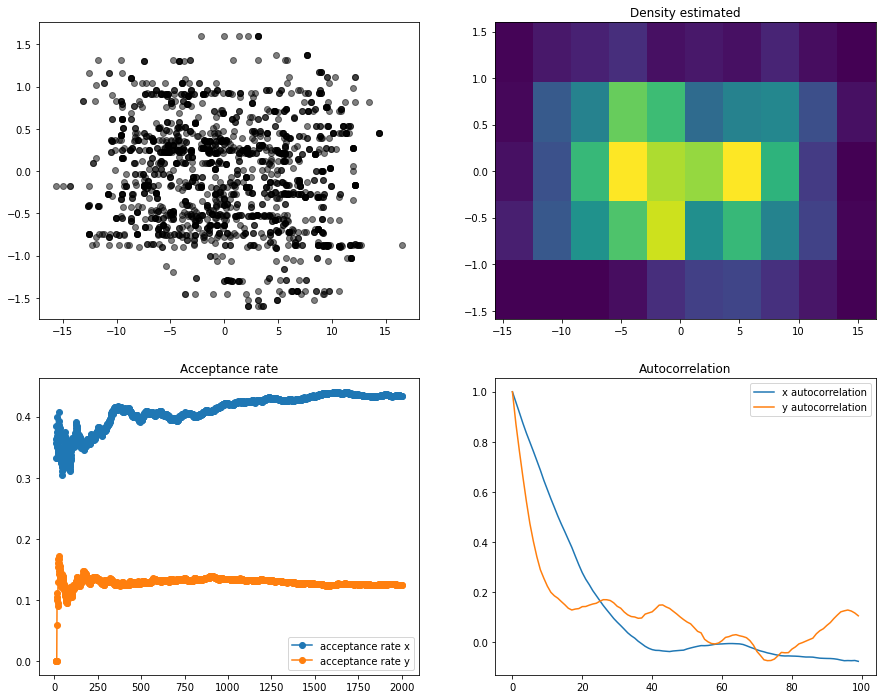

In [5]:
n = 2000

np.random.seed(0)
X, Y, acc_rates_x, acc_rates_y = P(x=0, y=0, n_iter=n, burn_in=0.1)
plt.figure(figsize=(15,12));

plt.subplot(221);
plt.scatter(X, Y, alpha=0.5, c="black");

plt.subplot(222);
plt.hist2d(X,Y, bins=[10,5]);
plt.title("Density estimated");

plt.subplot(223);
plt.plot(range(10,n), acc_rates_x[10:], label="acceptance rate x", marker="o");
plt.plot(range(10,n), acc_rates_y[10:], label="acceptance rate y", marker="o");
plt.legend();
plt.title("Acceptance rate");

plt.subplot(224);
x_correlation = [pd.Series(X).autocorr(i) for i in range(100)]
y_correlation = [pd.Series(Y).autocorr(i) for i in range(100)]
plt.plot(x_correlation, label="x autocorrelation");
plt.plot(y_correlation, label="y autocorrelation");
plt.legend();
plt.title("Autocorrelation");

We find back an approximation of the probability density.

One can adapt the standard variations of random walks to be more efficient.

## 1.B - Adaptive Metropolis-Hastings within Gibbs sampler

### 1.

In [6]:
def adapt_mh(x, y, n_iter, burn_in=0, batch_size=50):
    X, Y = [], []
    l_x = np.log(1)
    l_y = np.log(1)
    acc_rate_x, acc_rate_y = 0, 0
    batch_rate_x, batch_rate_y = 0, 0
    acc_rates_x, acc_rates_y = [], []
    j = 0
    for i in range(1, n_iter+1):
        if i % batch_size == 0:
            j += 1
            delta = min(0.01, 1/np.sqrt(j))
            l_x += (batch_rate_x > 0.24)*delta
            l_y += (batch_rate_y > 0.24)*delta
            batch_rate_x, batch_rate_y = 0, 0
        if np.random.rand() < 0.5:
            x2 = x + np.exp(l_x)*np.random.randn()
            y2 = y
            updated_x = True
        else:
            x2 = x
            y2 = y + np.exp(l_y)*np.random.randn()
            updated_x = False
        alpha = min(1, pi(x2, y2, a)/pi(x, y, a))
        if np.random.rand() < alpha:
            x = x2
            y = y2
            if updated_x:
                acc_rate_x += 1
                batch_rate_x += 1/batch_size
            else:
                acc_rate_y += 1
                batch_rate_y += 1/batch_size
        acc_rates_x.append(acc_rate_x/i)
        acc_rates_y.append(acc_rate_y/i) 
        X.append(x)
        Y.append(y)
    start = int(burn_in*n_iter)
    return X[start:], Y[start:], acc_rates_x, acc_rates_y

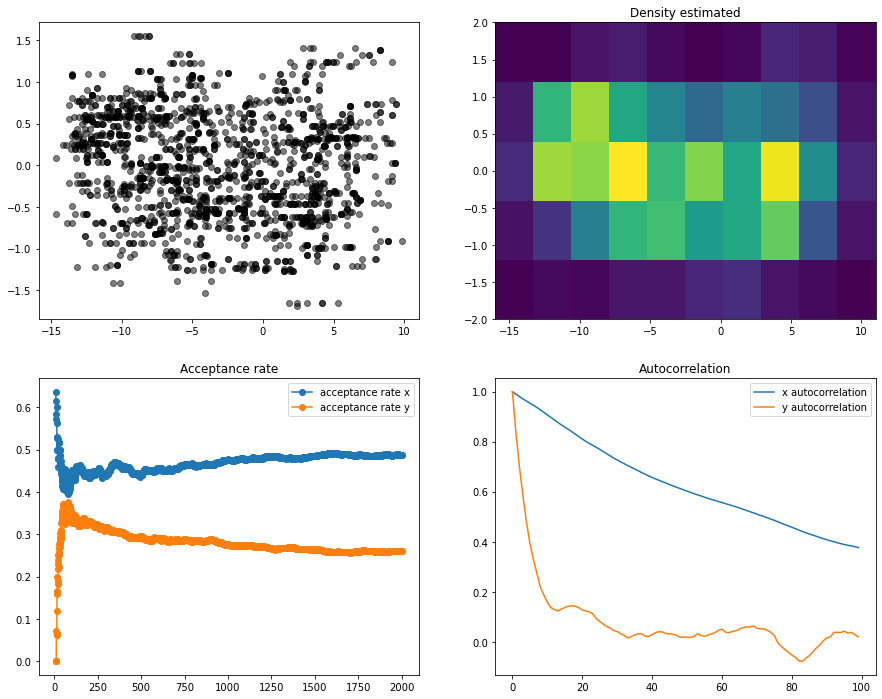

In [7]:
n = 2000

np.random.seed(0)
X, Y, acc_rates_x, acc_rates_y = adapt_mh(x=0, y=0, n_iter=n, burn_in=0.1)
plt.figure(figsize=(15,12));

plt.subplot(221);
plt.scatter(X, Y, alpha=0.5, c="black");

plt.subplot(222);
plt.hist2d(X,Y, bins=[10,5], range=[[-16,11],[-2,2]]);
plt.title("Density estimated");

plt.subplot(223);
plt.plot(range(10,n), acc_rates_x[10:], label="acceptance rate x", marker="o");
plt.plot(range(10,n), acc_rates_y[10:], label="acceptance rate y", marker="o");
plt.legend();
plt.title("Acceptance rate");

plt.subplot(224);
x_correlation = [pd.Series(X).autocorr(i) for i in range(100)]
y_correlation = [pd.Series(Y).autocorr(i) for i in range(100)]
plt.plot(x_correlation, label="x autocorrelation");
plt.plot(y_correlation, label="y autocorrelation");
plt.legend();
plt.title("Autocorrelation");

### 2.

In [8]:
f = lambda x, B: np.exp(-x[0]**2 /200 -1/2 * (x[1] + B*x[0]**2 - 100*B)**2 - 1/2*(x**2).sum() + 1/2 * (x[0]**2 + x[1]**2))

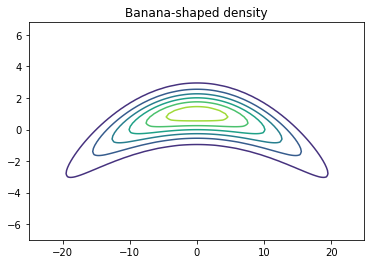

In [9]:
d = 2
B = 0.01
delta = 0.2
x = np.arange(-25, 25, delta)
y = np.arange(-7, 7, delta)
x, y = np.meshgrid(x, y)
z = np.array([[f(np.array([x[i,j],y[i,j]]), B) for j in range(x.shape[1])] for i in range(x.shape[0])])
plt.contour(x, y, z);
plt.title("Banana-shaped density");

We are going to simulate this banana density using the adaptative Metropolis-Hastings within Gibbs sampler.

In [10]:
def adapt_mh_banana(x0, n_iter, d, B=B, burn_in=0, batch_size=50):
    x = x0.copy()
    X = np.empty((n_iter,d))
    l_x = np.log(1)*np.ones(d)
    acc_rate_x = np.zeros(d)
    batch_rate_x = np.zeros(d)
    acc_rates_x = np.empty((n_iter,d))
    j = 0
    for i in range(1, n_iter+1):
        if i % batch_size == 0:
            j += 1
            delta = min(0.01, 1/np.sqrt(j))
            l_x += (batch_rate_x > 0.24)*delta
            batch_rate_x = np.zeros(d)            
        dim_sampled = np.random.randint(d)
        x2 = x.copy()
        x2[dim_sampled] += np.exp(l_x[dim_sampled])*np.random.randn()
        alpha = min(1, f(x2, B)/f(x, B))
        if np.random.rand() < alpha:
            x = x2.copy()
            acc_rate_x[dim_sampled] += 1
            batch_rate_x[dim_sampled] += 1/batch_size
        acc_rates_x[i-1] = acc_rate_x.copy()/i
        X[i-1] = x.copy()
    start = int(burn_in*n_iter)
    return X[start:], acc_rates_x

### $d=2$: dimension of banana-shaped density

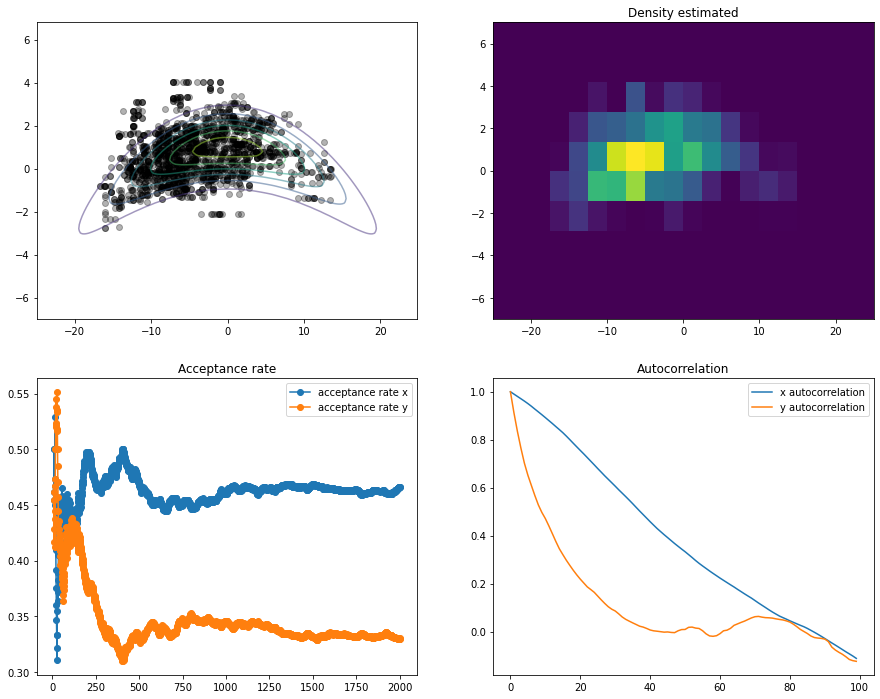

In [11]:
n = 2000
d = 2
B = 0.01

np.random.seed(0)
X, acc_rates_x = adapt_mh_banana(x0=np.zeros(d), n_iter=n, d=d, burn_in=0.1)
plt.figure(figsize=(15,12));

plt.subplot(221);
delta = 0.2
x = np.arange(-25, 25, delta)
y = np.arange(-7, 7, delta)
x, y = np.meshgrid(x, y)
z = np.array([[f(np.array([x[i,j],y[i,j]]), B) for j in range(x.shape[1])] for i in range(x.shape[0])])
plt.contour(x, y, z, alpha=0.5);
plt.scatter(X[:,0], X[:,1], alpha=0.3, c="black");

plt.subplot(222);
plt.hist2d(X[:,0], X[:,1], bins=[20,10], range=[[-25,25],[-7,7]]);
plt.title("Density estimated");

plt.subplot(223);
plt.plot(range(10,n), acc_rates_x[10:,0], label="acceptance rate x", marker="o");
plt.plot(range(10,n), acc_rates_x[10:,1], label="acceptance rate y", marker="o");
plt.legend();
plt.title("Acceptance rate");

plt.subplot(224);
x_correlation = [pd.Series(X[:,0]).autocorr(i) for i in range(100)]
y_correlation = [pd.Series(X[:,1]).autocorr(i) for i in range(100)]
plt.plot(x_correlation, label="x autocorrelation");
plt.plot(y_correlation, label="y autocorrelation");
plt.legend();
plt.title("Autocorrelation");

### $d=20$: dimension of banana-shaped density

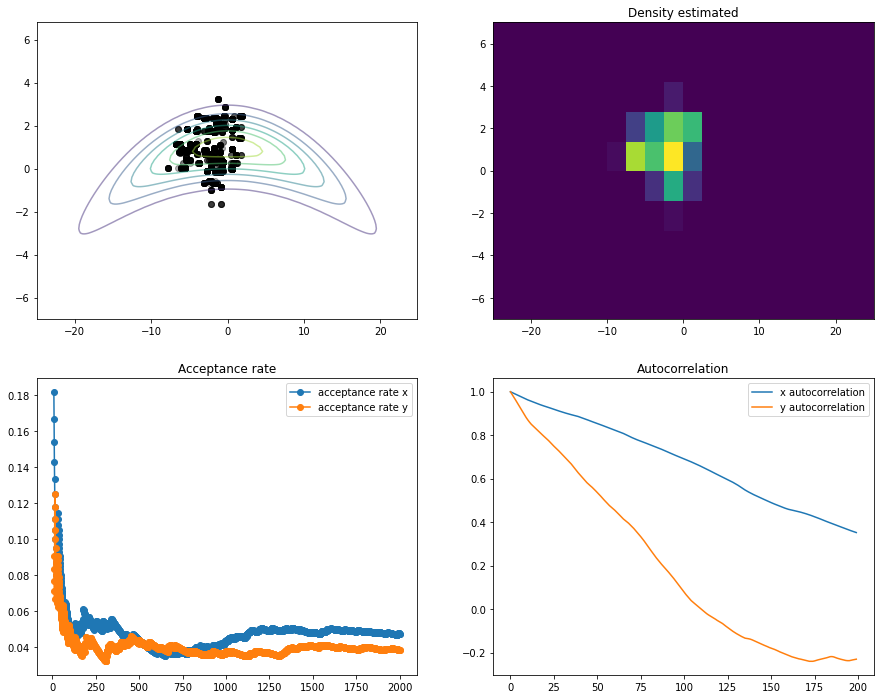

In [12]:
n = 2000
d = 20
B = 0.01

np.random.seed(0)
X, acc_rates_x = adapt_mh_banana(x0=np.zeros(d), n_iter=n, d=d, burn_in=0.1)
plt.figure(figsize=(15,12));

plt.subplot(221);
delta = 0.2
x = np.arange(-25, 25, delta)
y = np.arange(-7, 7, delta)
x, y = np.meshgrid(x, y)
z = np.array([[f(np.array([x[i,j],y[i,j]]), B) for j in range(x.shape[1])] for i in range(x.shape[0])])
plt.contour(x, y, z, alpha=0.5);
plt.scatter(X[:,0], X[:,1], alpha=0.3, c="black");

plt.subplot(222);
plt.hist2d(X[:,0], X[:,1], bins=[20,10], range=[[-25,25],[-7,7]]);
plt.title("Density estimated");

plt.subplot(223);
plt.plot(range(10,n), acc_rates_x[10:,0], label="acceptance rate x", marker="o");
plt.plot(range(10,n), acc_rates_x[10:,1], label="acceptance rate y", marker="o");
plt.legend();
plt.title("Acceptance rate");

plt.subplot(224);
x_correlation = [pd.Series(X[:,0]).autocorr(i) for i in range(200)]
y_correlation = [pd.Series(X[:,1]).autocorr(i) for i in range(200)]
plt.plot(x_correlation, label="x autocorrelation");
plt.plot(y_correlation, label="y autocorrelation");
plt.legend();
plt.title("Autocorrelation");

In "high" dimension (d=20), the algorithm struggles accepting the samples and thus fails to provide a good density estimation.

---

## 2.A - A toy example: multimodal distribution

In [13]:
K = 20
mu = np.array([[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82],
               [3.25, 3.47], [1.70, 0.50], [4.59, 5.60], [6.91, 5.81], [6.87, 5.40],
               [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50],
               [4.93, 1.50], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]])
w = 0.05*np.ones(K)
sigma = 0.1*np.ones(K)
pi = lambda x, w, mu, sigma: np.array([w[i]/(2*np.pi*sigma[i]**2) * np.exp(-1/(2*sigma[i]**2) * (x-mu[i])@(x-mu[i])) for i in range(len(w))]).sum()

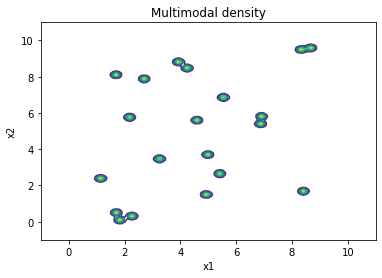

In [14]:
d = 2
B = 0.01
delta = 0.1
x = np.arange(-0.2, 10.2, delta)
y = np.arange(-0.2, 10.2, delta)
x, y = np.meshgrid(x, y)
z = np.array([[pi(np.array([x[i,j],y[i,j]]), w, mu, sigma) for j in range(x.shape[1])] for i in range(x.shape[0])])
plt.contour(x, y, z);
plt.title("Multimodal density");
plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim(-1,11);
plt.ylim(-1,11);

### Metropolis-Hastings algorithm

In [15]:
def mh_multimodal(x0, n_iter, l_x=None, burn_in=0):
    x = x0.copy()
    d = x.shape[0]
    X = np.empty((n_iter,d))
    if l_x is None:
        l_x = np.log(1)*np.ones(d)
    acc_rate_x = np.zeros(d)
    acc_rates_x = np.empty((n_iter,d))
    for i in range(1, n_iter+1):           
        dim_sampled = np.random.randint(d)
        x2 = x.copy()
        x2[dim_sampled] += np.exp(l_x[dim_sampled])*np.random.randn()
        alpha = min(1, pi(x2, w, mu, sigma)/pi(x, w, mu, sigma))
        if np.random.rand() < alpha:
            x = x2.copy()
            acc_rate_x[dim_sampled] += 1
        acc_rates_x[i-1] = acc_rate_x.copy()/i
        X[i-1] = x.copy()
    start = int(burn_in*n_iter)
    return X[start:], acc_rates_x

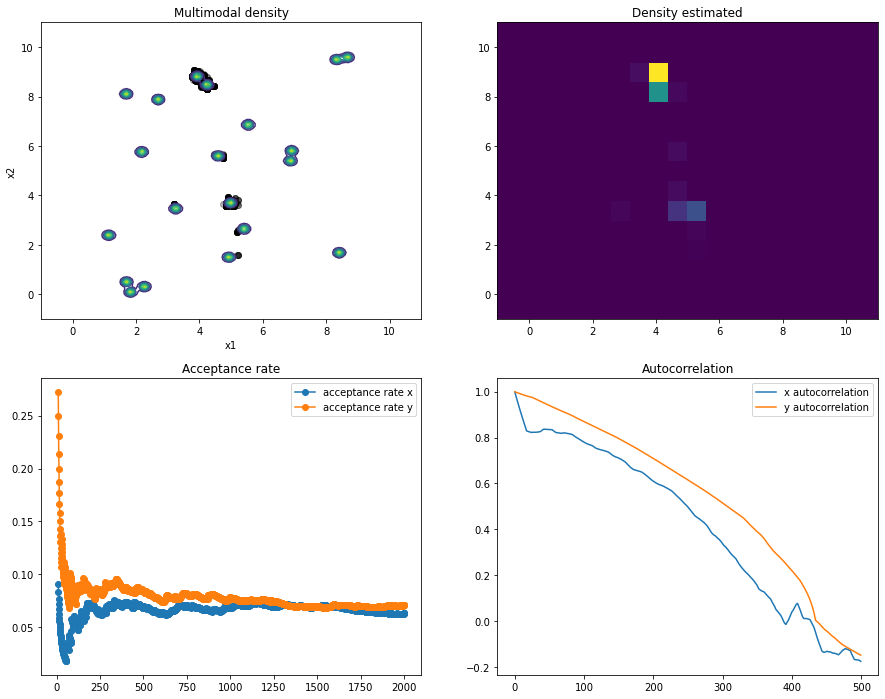

In [16]:
n = 2000

np.random.seed(0)
X, acc_rates_x = mh_multimodal(x0=np.array([5,5], dtype=np.float), n_iter=n, burn_in=0.1)
plt.figure(figsize=(15,12));

plt.subplot(221);
delta = 0.1
x = np.arange(-0.2, 10.2, delta)
y = np.arange(-0.2, 10.2, delta)
x, y = np.meshgrid(x, y)
z = np.array([[pi(np.array([x[i,j],y[i,j]]), w, mu, sigma) for j in range(x.shape[1])] for i in range(x.shape[0])])
plt.contour(x, y, z);
plt.title("Multimodal density");
plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim(-1,11);
plt.ylim(-1,11);
plt.scatter(X[:,0], X[:,1], alpha=0.3, c="black");

plt.subplot(222);
plt.hist2d(X[:,0], X[:,1], bins=[20,15], range=[[-1,11],[-1,11]]);
plt.title("Density estimated");

plt.subplot(223);
plt.plot(range(10,n), acc_rates_x[10:,0], label="acceptance rate x", marker="o");
plt.plot(range(10,n), acc_rates_x[10:,1], label="acceptance rate y", marker="o");
plt.legend();
plt.title("Acceptance rate");

plt.subplot(224);
x_correlation = [pd.Series(X[:,0]).autocorr(i) for i in range(500)]
y_correlation = [pd.Series(X[:,1]).autocorr(i) for i in range(500)]
plt.plot(x_correlation, label="x autocorrelation");
plt.plot(y_correlation, label="y autocorrelation");
plt.legend();
plt.title("Autocorrelation");

### Adaptive Metropolis-Hastings

In [17]:
def adapt_mh_multimodal(x0, n_iter, burn_in=0, batch_size=50):
    x = x0.copy()
    d = x.shape[0]
    X = np.empty((n_iter,d))
    l_x = np.log(1)*np.ones(d)
    acc_rate_x = np.zeros(d)
    batch_rate_x = np.zeros(d)
    acc_rates_x = np.empty((n_iter,d))
    j = 0
    for i in range(1, n_iter+1):
        if i % batch_size == 0:
            j += 1
            delta = min(0.01, 1/np.sqrt(j))
            l_x += (batch_rate_x > 0.24)*delta
            batch_rate_x = np.zeros(d)            
        dim_sampled = np.random.randint(d)
        x2 = x.copy()
        x2[dim_sampled] += np.exp(l_x[dim_sampled])*np.random.randn()
        alpha = min(1, pi(x2, w, mu, sigma)/pi(x, w, mu, sigma))
        if np.random.rand() < alpha:
            x = x2.copy()
            acc_rate_x[dim_sampled] += 1
            batch_rate_x[dim_sampled] += 1/batch_size
        acc_rates_x[i-1] = acc_rate_x.copy()/i
        X[i-1] = x.copy()
    start = int(burn_in*n_iter)
    return X[start:], acc_rates_x

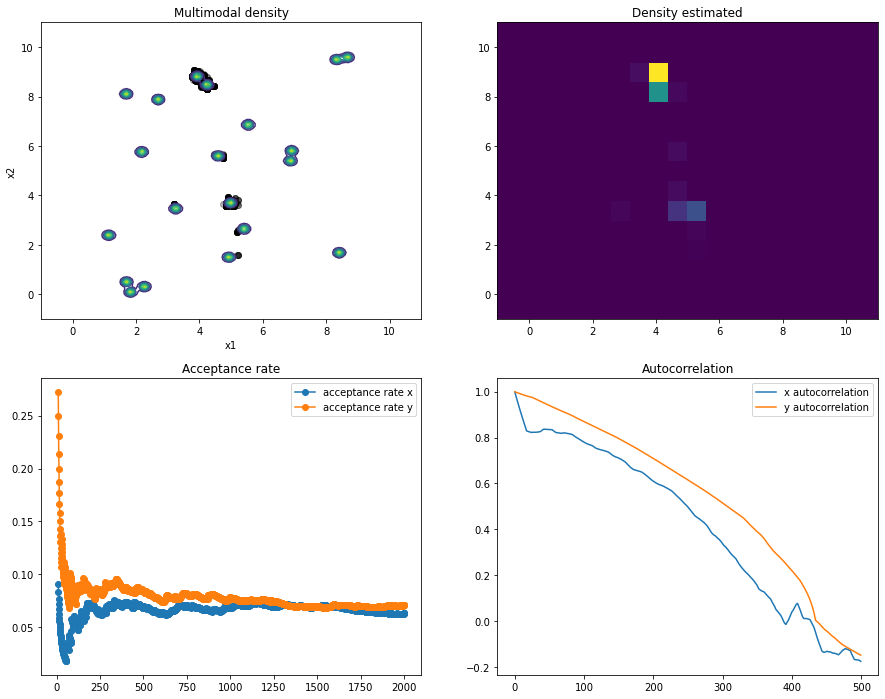

In [18]:
n = 2000

np.random.seed(0)
X, acc_rates_x = adapt_mh_multimodal(x0=np.array([5,5], dtype=np.float), n_iter=n, burn_in=0.1)
plt.figure(figsize=(15,12));

plt.subplot(221);
delta = 0.1
x = np.arange(-0.2, 10.2, delta)
y = np.arange(-0.2, 10.2, delta)
x, y = np.meshgrid(x, y)
z = np.array([[pi(np.array([x[i,j],y[i,j]]), w, mu, sigma) for j in range(x.shape[1])] for i in range(x.shape[0])])
plt.contour(x, y, z);
plt.title("Multimodal density");
plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim(-1,11);
plt.ylim(-1,11);
plt.scatter(X[:,0], X[:,1], alpha=0.3, c="black");

plt.subplot(222);
plt.hist2d(X[:,0], X[:,1], bins=[20,15], range=[[-1,11],[-1,11]]);
plt.title("Density estimated");

plt.subplot(223);
plt.plot(range(10,n), acc_rates_x[10:,0], label="acceptance rate x", marker="o");
plt.plot(range(10,n), acc_rates_x[10:,1], label="acceptance rate y", marker="o");
plt.legend();
plt.title("Acceptance rate");

plt.subplot(224);
x_correlation = [pd.Series(X[:,0]).autocorr(i) for i in range(500)]
y_correlation = [pd.Series(X[:,1]).autocorr(i) for i in range(500)]
plt.plot(x_correlation, label="x autocorrelation");
plt.plot(y_correlation, label="y autocorrelation");
plt.legend();
plt.title("Autocorrelation");

Both algorithm fail to sample from $\pi$ as they get stuck in some local modes of the multimodal distribution.

## 2.B - Parallel Tempering

### 1.

In [19]:
def mh_tempering(x0, n_iter, T, pi, burn_in=0):
    K = len(T)
    d = x0.shape[1]
    x = x0.copy()
    Y = np.empty((K,d))
    X = np.empty((n_iter,d))
    tau = 0.25*np.sqrt(T)
    swap_rate = 0
    swap_rates = np.empty(n_iter)
    for i in range(1, n_iter+1):           
        Y = x.copy()
        for k in range(K):
            Y[k] = np.random.multivariate_normal(
                mean=x[k],
                cov=tau[k]**2*np.identity(d))
        k_i, k_j = np.random.choice(range(K), size=2, replace=False)
        pi_i_j = pi(Y[k_j], w, mu, sigma)**(1/T[k_i])
        pi_j_i = pi(Y[k_i], w, mu, sigma)**(1/T[k_j])
        pi_i_i = pi(Y[k_i], w, mu, sigma)**(1/T[k_i])
        pi_j_j = pi(Y[k_j], w, mu, sigma)**(1/T[k_j])
        alpha = min(1, (pi_i_j*pi_j_i)/(pi_i_i*pi_j_j))
        x = Y.copy()
        if np.random.rand() < alpha:
            x[k_i], x[k_j] = x[k_j], x[k_i]
            swap_rate += 1
        swap_rates[i-1] = swap_rate/i
        X[i-1] = x[-1].copy()
    start = int(burn_in*n_iter)
    return X[start:], swap_rates

### 2.

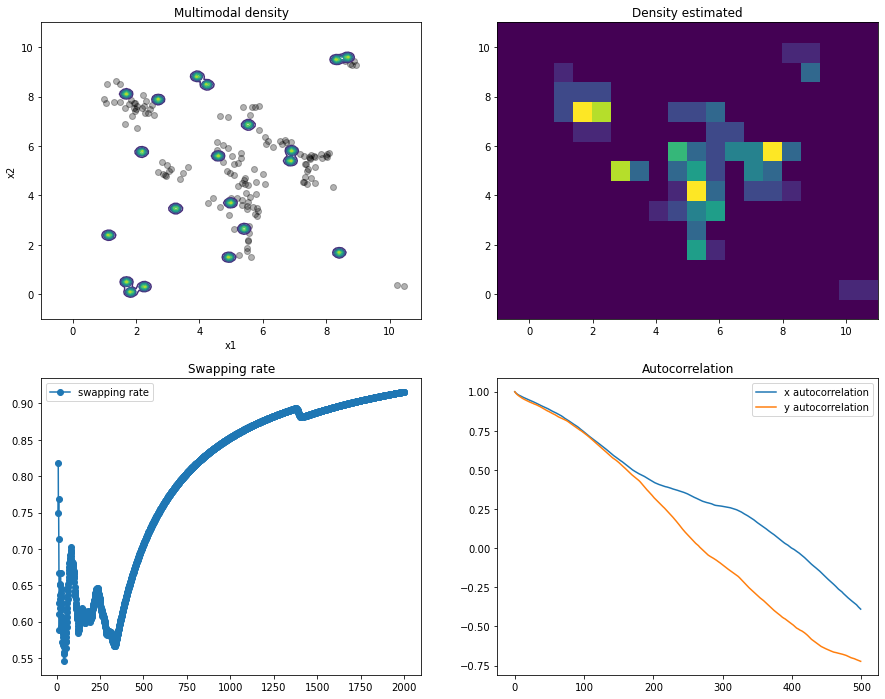

In [20]:
T = np.array([60, 21.6, 7.7, 2.8, 1])
n = 2000

np.random.seed(0)
x0 = np.array([10*np.random.rand(d) for _ in T])
X, swap_rates = mh_tempering(x0=x0, n_iter=n, T=T, pi=pi, burn_in=0.1)
plt.figure(figsize=(15,12));

plt.subplot(221);
delta = 0.1
x = np.arange(-0.2, 10.2, delta)
y = np.arange(-0.2, 10.2, delta)
x, y = np.meshgrid(x, y)
z = np.array([[pi(np.array([x[i,j],y[i,j]]), w, mu, sigma) for j in range(x.shape[1])] for i in range(x.shape[0])])
plt.contour(x, y, z);
plt.title("Multimodal density");
plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim(-1,11);
plt.ylim(-1,11);
plt.scatter(X[:,0], X[:,1], alpha=0.3, c="black");

plt.subplot(222);
plt.hist2d(X[:,0], X[:,1], bins=[20,15], range=[[-1,11],[-1,11]]);
plt.title("Density estimated");

plt.subplot(223);
plt.plot(range(10,n), swap_rates[10:], label="swapping rate", marker="o");
plt.legend();
plt.title("Swapping rate");

plt.subplot(224);
x_correlation = [pd.Series(X[:,0]).autocorr(i) for i in range(500)]
y_correlation = [pd.Series(X[:,1]).autocorr(i) for i in range(500)]
plt.plot(x_correlation, label="x autocorrelation");
plt.plot(y_correlation, label="y autocorrelation");
plt.legend();
plt.title("Autocorrelation");

Parallel tempering suceeds in exploring more modes.